In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
raw_data = pd.read_csv('../Data/Detect AI Generated Text/train_essays.csv')

In [49]:
raw_data.columns

Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')

In [50]:
raw_data.head(2)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0


<Axes: xlabel='generated'>

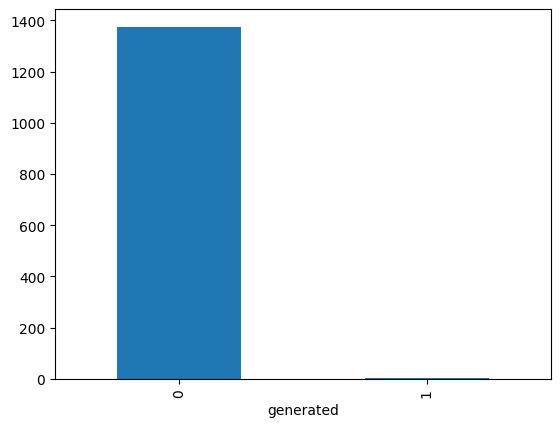

In [51]:
raw_data['generated'].value_counts().plot(kind='bar')

In [52]:
raw_data['text_len'] = raw_data['text'].apply(lambda x: len(x.split()))

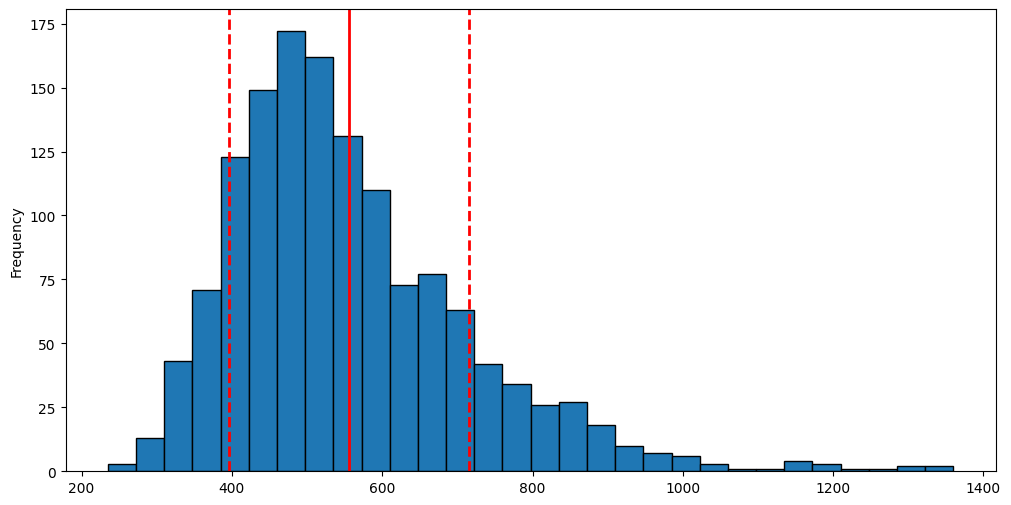

In [53]:
raw_data['text_len'].plot(kind='hist', bins=30, figsize=(12,6), edgecolor='black', linewidth=1.0)
# Add a vertical line at the mean.
plt.axvline(raw_data['text_len'].mean(), color='r', linestyle='solid', linewidth=2)
# Add a vertical line at one standard deviation above the mean.
plt.axvline(raw_data['text_len'].mean() + raw_data['text_len'].std(), color='r', linestyle='dashed', linewidth=2)
# Add a vertical line at one standard deviation below the mean.
plt.axvline(raw_data['text_len'].mean()-raw_data['text_len'].std(), color='r', linestyle='dashed', linewidth=2)

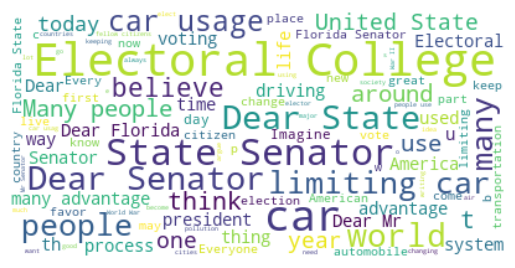

In [54]:
# Word cloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(raw_data['text'].to_string())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
# Pull text from the generated essays
generated = raw_data[raw_data['generated'] == True]

In [55]:
# N-grams
from nltk import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

def get_ngrams(text, n):
    n_grams = ngrams(word_tokenize(text), n)
    return [' '.join(grams) for grams in n_grams]

def get_top_ngrams(corpus, n, k):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

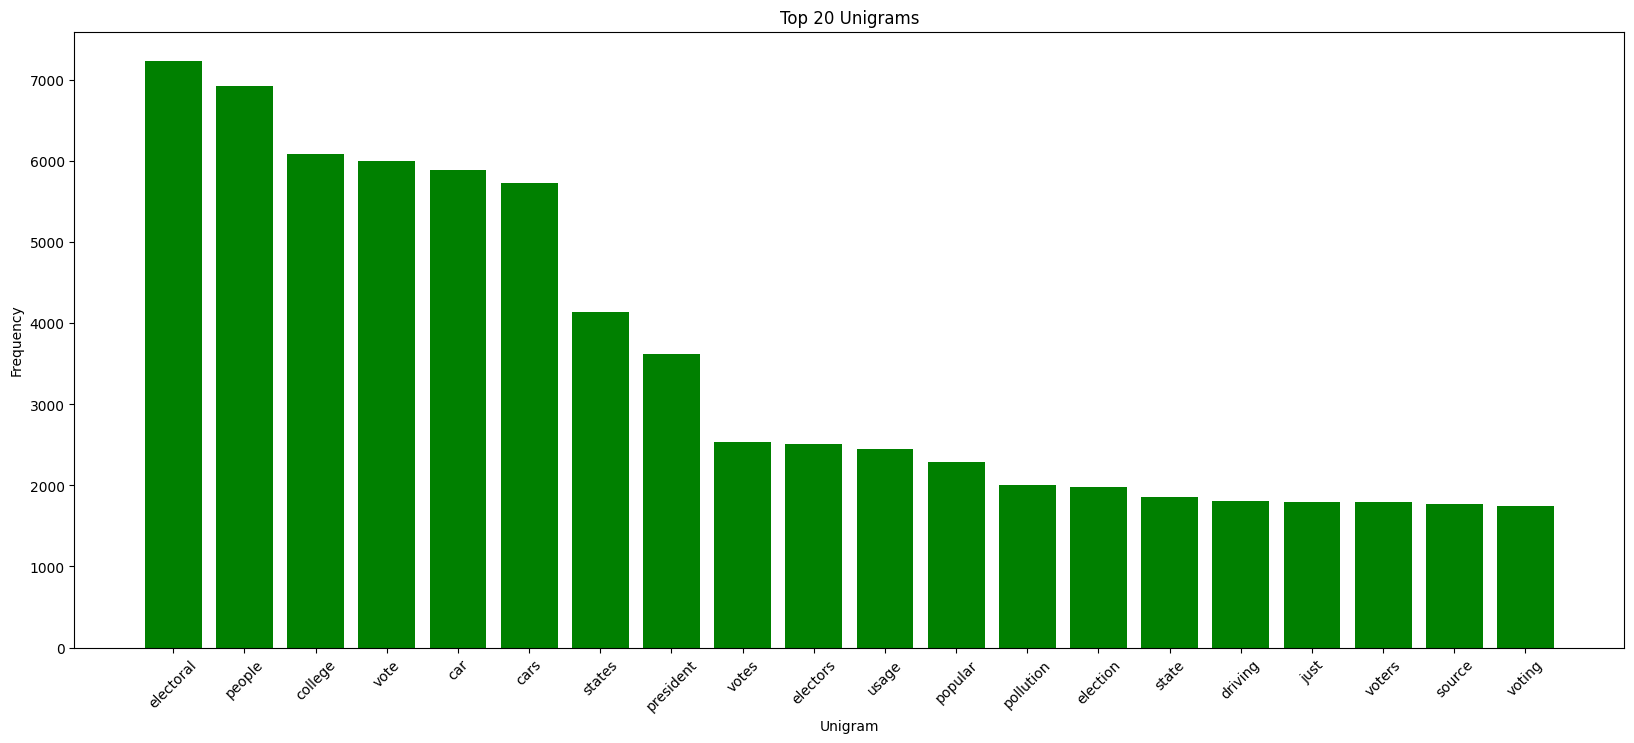

In [61]:
# Unigrams for student essays
unigrams = get_top_ngrams(raw_data['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.title('Top 20 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

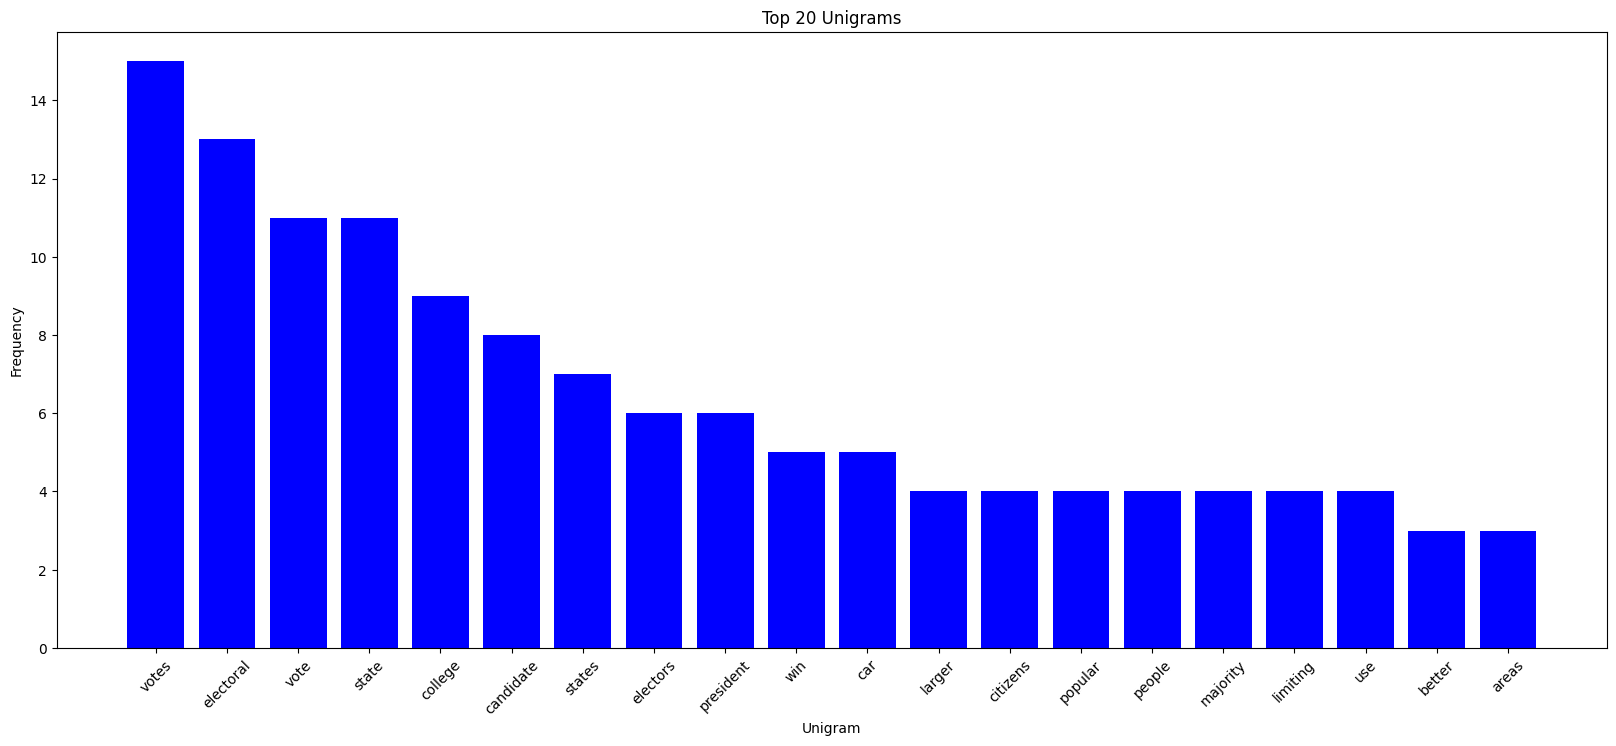

In [77]:
# Unigrams for generated essays
unigrams = get_top_ngrams(generated['text'], 1, 20)
unigrams = dict(unigrams)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='b')
plt.title('Top 20 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:

import transformers
from transformers import pipeline

generator = pipeline('text-generation', model='gpt2')
generator('This is a test', max_length=100, num_return_sequences=5)



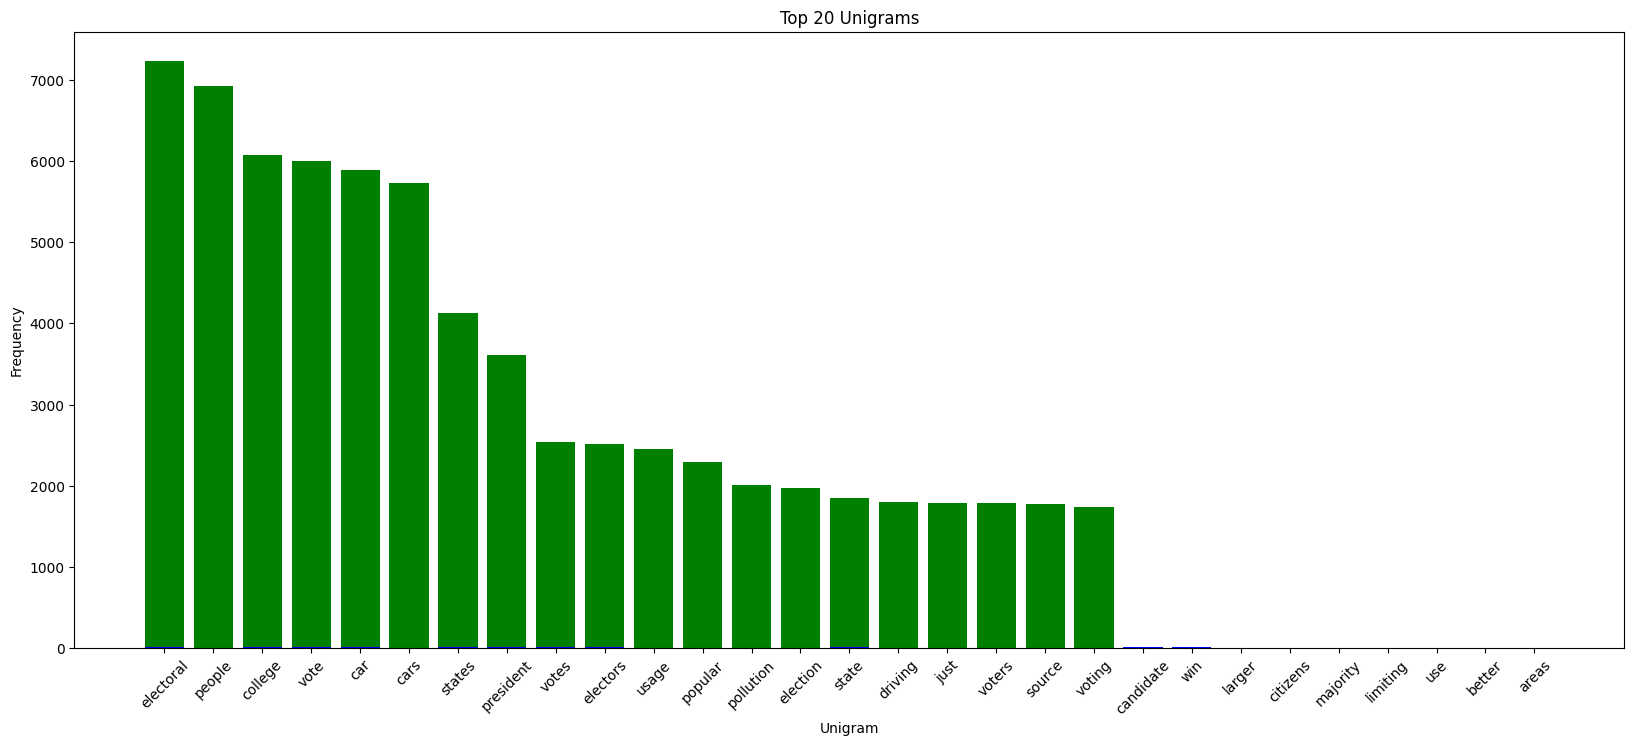

In [78]:
# Compare unigrams
unigrams = get_top_ngrams(raw_data['text'], 1, 20)
unigrams = dict(unigrams)
unigrams_gen = get_top_ngrams(generated['text'], 1, 20)
unigrams_gen = dict(unigrams_gen)
plt.figure(figsize=(20,8))
plt.bar(unigrams.keys(), unigrams.values(), color='g')
plt.bar(unigrams_gen.keys(), unigrams_gen.values(), color='b')
plt.title('Top 20 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

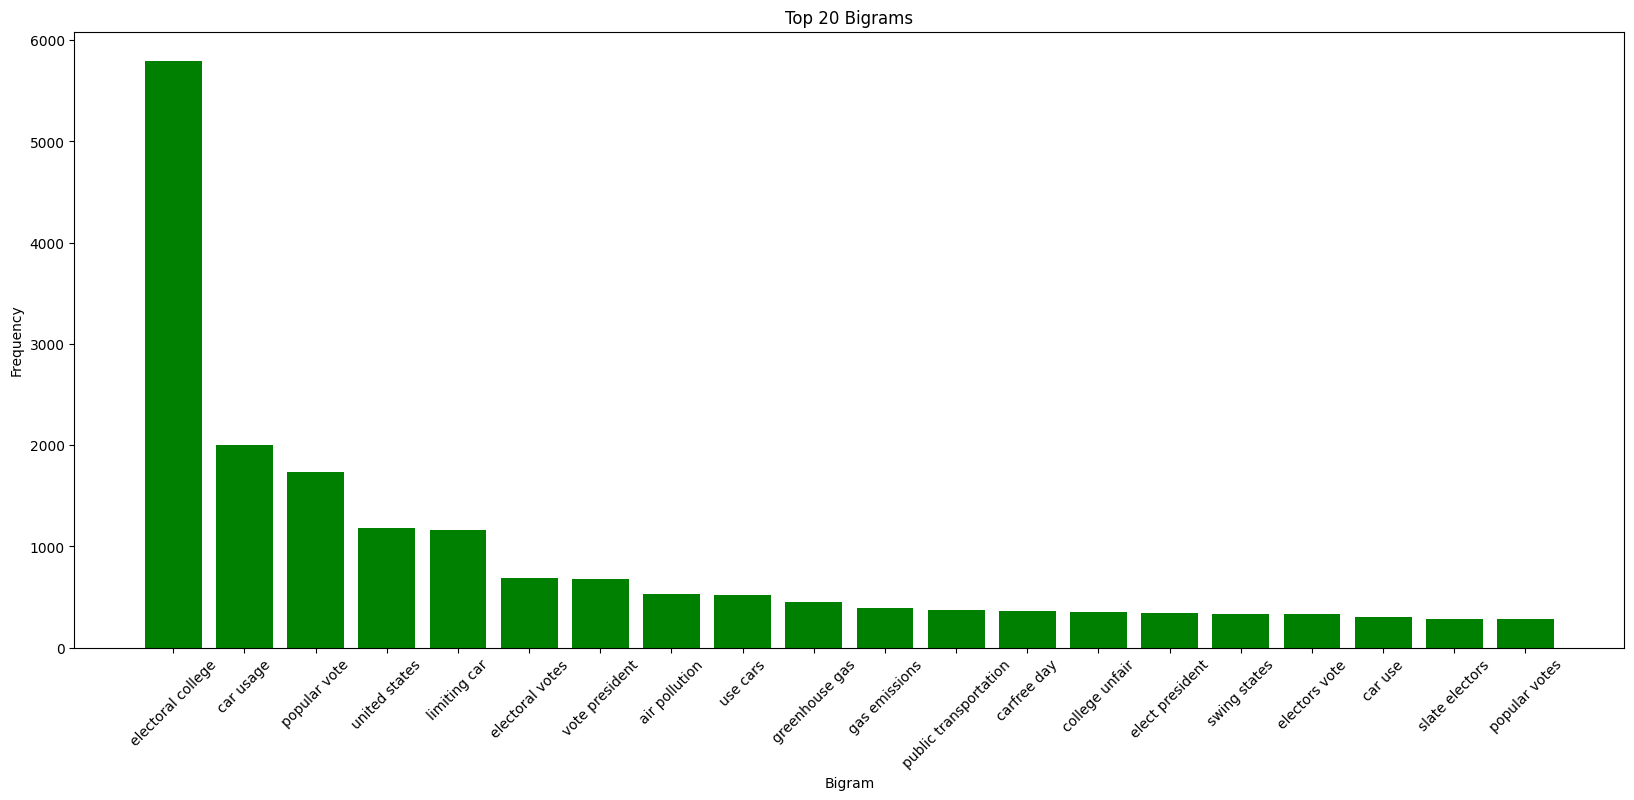

In [62]:
# Bigrams
bigrams = get_top_ngrams(raw_data['text'], 2, 20)
bigrams = dict(bigrams)
plt.figure(figsize=(20,8))
plt.bar(bigrams.keys(), bigrams.values(), color='g')
plt.title('Top 20 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

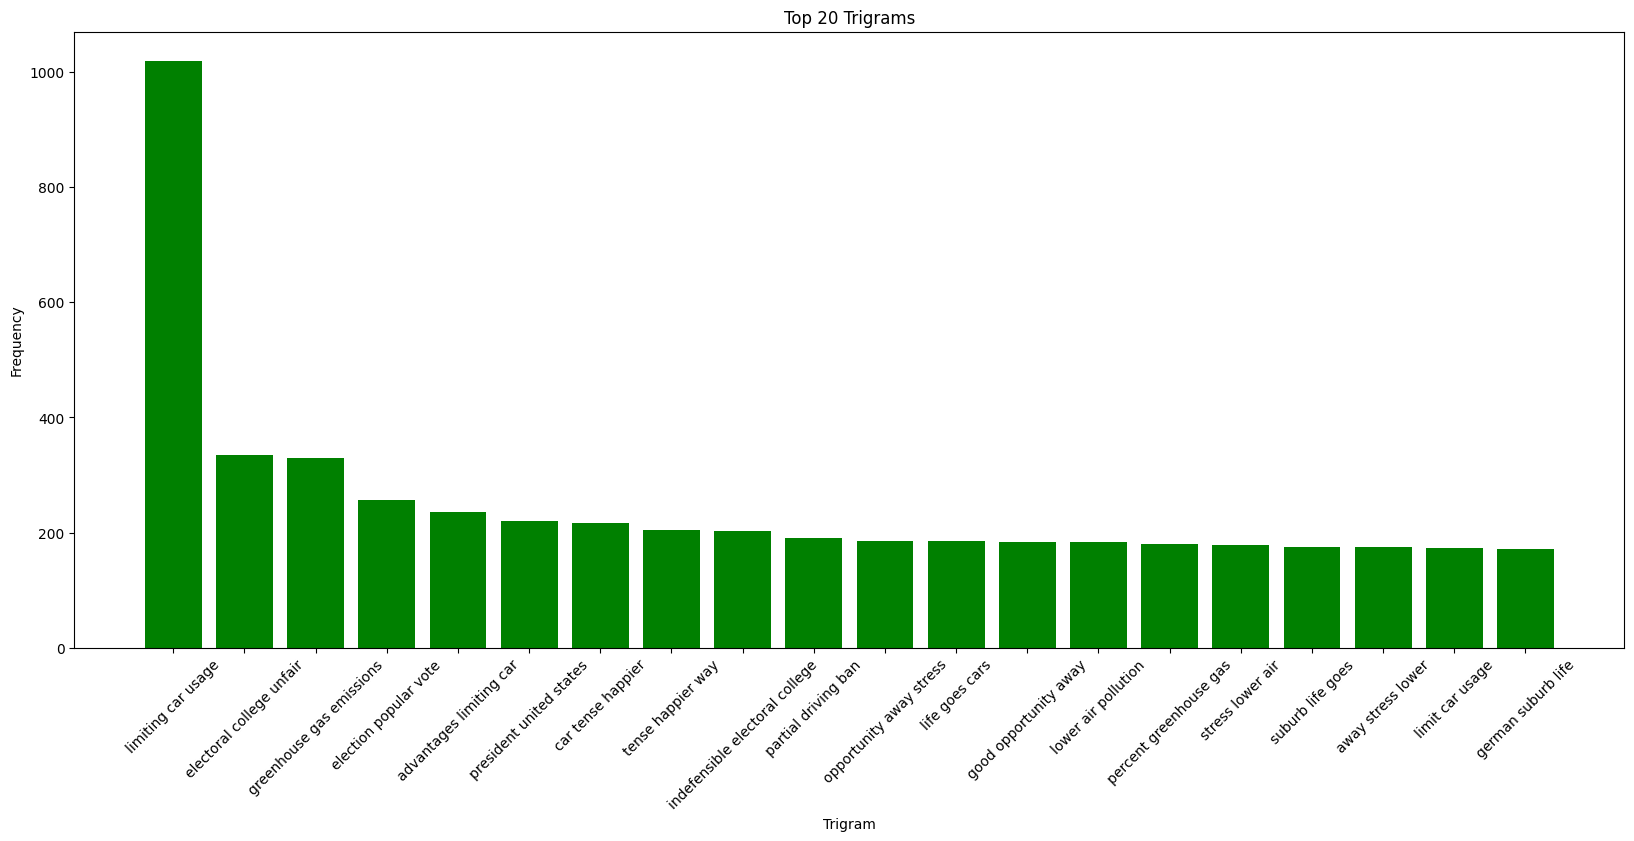

In [63]:
# Trigrams
trigrams = get_top_ngrams(raw_data['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='g')
plt.title('Top 20 Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

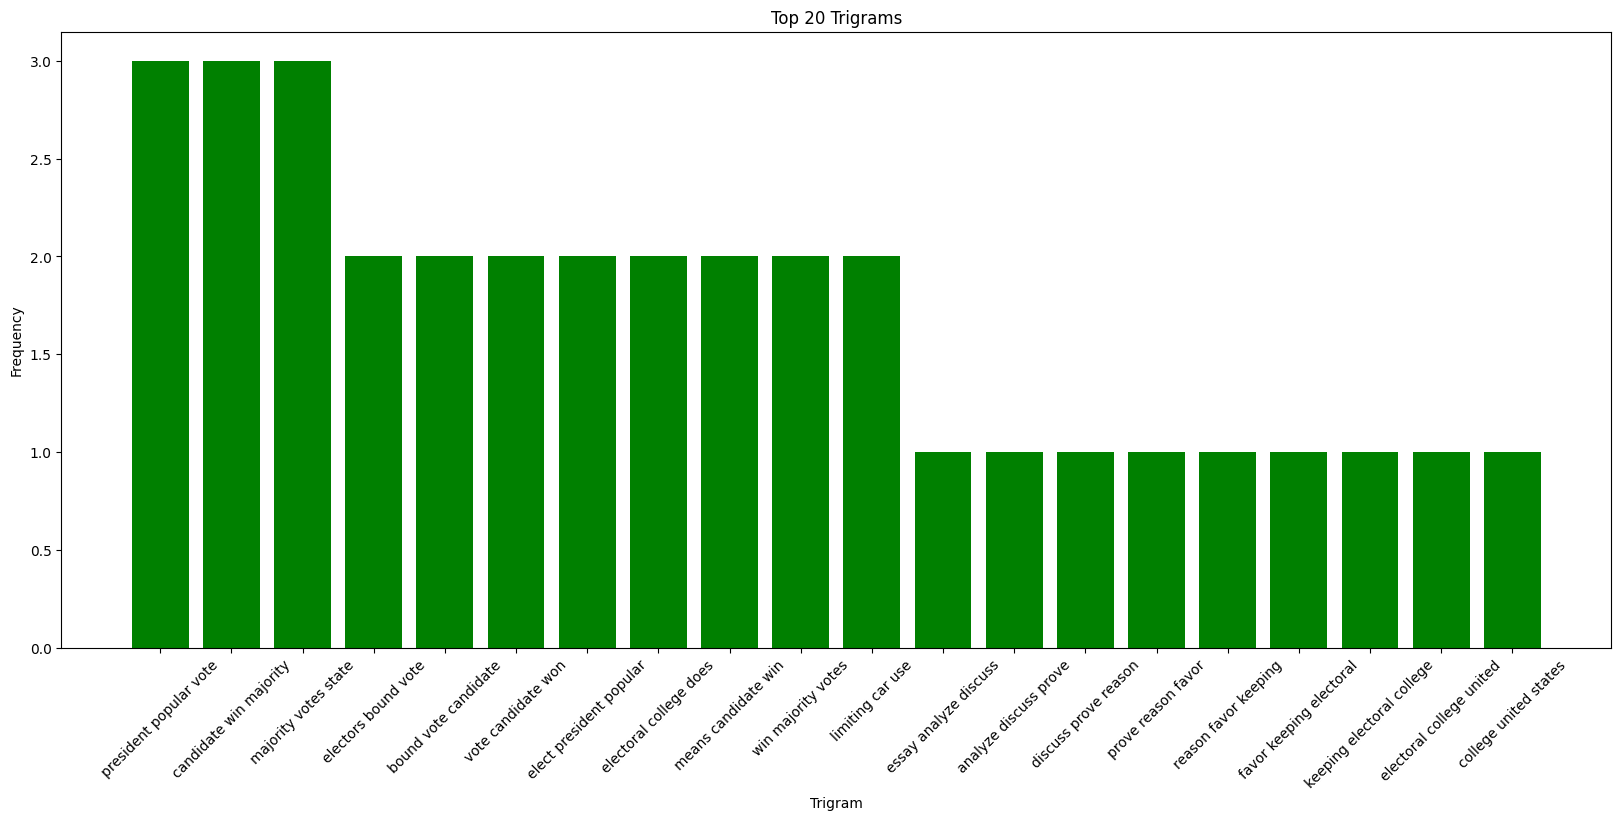

In [74]:
# Trigrams
trigrams = get_top_ngrams(generated['text'], 3, 20)
trigrams = dict(trigrams)
plt.figure(figsize=(20,8))
plt.bar(trigrams.keys(), trigrams.values(), color='g')
plt.title('Top 20 Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

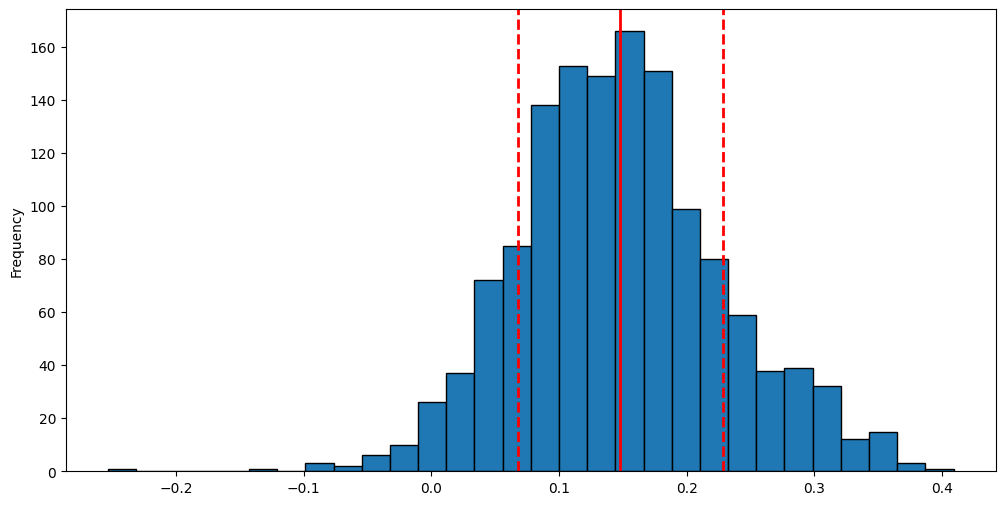

In [59]:
# Sentiment Analysis

from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

raw_data['sentiment'] = raw_data['text'].apply(get_sentiment)

raw_data['sentiment'].plot(kind='hist', bins=30, figsize=(12,6), edgecolor='black', linewidth=1.0)
# Add a vertical line at the mean.
plt.axvline(raw_data['sentiment'].mean(), color='r', linestyle='solid', linewidth=2)
# Add a vertical line at one standard deviation above the mean.
plt.axvline(raw_data['sentiment'].mean() + raw_data['sentiment'].std(), color='r', linestyle='dashed', linewidth=2)
# Add a vertical line at one standard deviation below the mean.
plt.axvline(raw_data['sentiment'].mean()-raw_data['sentiment'].std(), color='r', linestyle='dashed', linewidth=2)